In [2]:
import numpy as np
import h5py
import glob
import os
import sys
import re
import matplotlib
#matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')
matplotlib.rc('text.latex', preamble=r'\usepackage{bm}')
import matplotlib.pyplot as plt
from astropy.table import Table, vstack
%matplotlib inline
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
from os.path import expanduser
from itertools import zip_longest
home = expanduser("~")
host = os.getenv('HOSTNAME')
print(host)

None


In [3]:
if host is not None:
    if 'bebop' in host:
        input_dir = '/lcrc/project/galsampler/Catalog_5000/OR_5000/'
        size_dir = '/lcrc/project/galsampler/Validation_Data/Sizes'
else:
    #input_dir = '/lus/eagle/projects/LastJourney/kovacs/Catalog_5000/OR_5000/'
    #size_dir = '/lus/eagle/projects/LastJourney/kovacs/Validation_Data/Sizes'
    #laptop
    input_dir = '/Users/kovacs/Catalog_5000/OR_5000/roman_rubin_2023_v1.1.3'
    size_dir = '/Users/kovacs/Validation_Data/Sizes'
    notebook_dir = '/Users/kovacs/cosmology/diff_notebooks'
fname = 'roman_rubin_2023_z_*_cutout_{}.hdf5'
from diffaux.validation.get_catalog_data import get_fhlist
from diffaux.validation.get_catalog_data import get_colnames
#from lsstdesc_diffsky.write_mock_to_disk import get_astropy_table
from diffaux.size_modeling import zhang_yang17

In [4]:
def read_Re_vs_Mstar_data(tmp, data, author, validation_info, sample=''):
    #collect M* values if not already in dict
    v = validation_info[author]
    if not all([cname in data.keys() for cname in v['M*_colnames']]):
        for col, colname in zip(v['M*_columns'], v['M*_colnames']):
            data[colname] = tmp[:, col]

    #collect M_med, R_e values for each z bin
    for n, zlo in enumerate(np.arange(v['z_lo'], v['z_hi'], v['dz'])):
        zhi = zlo + v['dz']
        #print(n, zlo, zhi)
        zlabel = '${:.1f} \\leq z < {:.1f}$'.format(zlo, zhi)
        if zlabel not in data.keys(): data[zlabel] = {}
        for i, colname  in enumerate(v['data_colnames']):
            col = len(v['M*_columns']) + i + n*len(v['data_colnames'])
            data[zlabel][colname.format(sample)] = tmp[:, col]
            
        data[zlabel] = complete_data_values(data[zlabel], author, validation_info, samples=sample)
    
    return data

def read_Re_vs_z_data(tmp, data, author, validation_info):

    # collect M* columns 
    v = validation_info[author]
    if 'format' in v.keys() and 'M*_by_row' in v['format']:
        for row, name in zip(v['M*_rows'], v['M*_rownames']):
            data[name] = tmp[row][tmp[row]>validation_info['filling_values']]
        #save colnames for later concatenation
        M_old = v['M*_rownames'][-1]
        M_new = validation_info['x-values']
        data[M_new] = np.asarray([])
        Mstars = np.unique(data[M_old])
        length = len(np.unique(data[M_old]))
    else:
        for col, colname in zip(v['M*_columns'], v['M*_colnames']):
            data[colname] = tmp[:, col]
    # collect z columns
    for col, z_name in zip(v['z_columns'], v['z_colnames']):
        if 'format' in v.keys() and 'M*_by_row' in v['format']:
            #save colnames for later concatenation (since only one z column in data)
            data[z_name] = tmp[len(v['M*_rows']):, col]
            z_new = validation_info['z-values']
            data[z_new] = np.asarray([])
        else:
            data[z_name] = tmp[:, col]

    # collect size data 
    for n, sample in enumerate(validation_info[author]['samples']):
        for i, colname in enumerate(v['data_colnames']):
            if 'format' in v.keys() and 'M*_by_row' in v['format']:
                #duplicate M* rows
                for j, Mstar in enumerate(Mstars):
                    col = len(v['z_columns']) + i + j*len(v['data_colnames']) + n*length*len(v['data_colnames'])
                    colname = colname.format(sample)
                    if colname not in data.keys():
                        data[colname] = np.asarray([])
                    #concatenate data columns
                    data[colname] = np.concatenate((data[colname], tmp[len(v['M*_rows']):, col]))
                    #concatenate z amd M* arrays
                    if i==0 and n==0: 
                        data[z_new] = np.concatenate((data[z_new], data[z_name]))
                        M_repeat = np.array([Mstar]*len(data[z_name]))
                        data[M_new] = np.concatenate((data[M_new], M_repeat))
            else:
                col = len(v['M*_columns']) + len(v['z_columns']) + i + n*len(v['data_colnames'])
                colname = colname.format(sample)
                data[colname] = tmp[:, col]
                
    data = complete_data_values(data, author, validation_info)

    #check 
    for k, v in data.items():
        if '_row' not in k:
            test = len(data[validation_info['z-values']])
            assert(len(v)==test), 'Mismatch in length of array {}, {} != {}'.format(k, len(v), test)

    return data

def read_Re_vs_z_Mstar_fits(tmp, data, author, validation_info):

    # collect M* columns 
    v = validation_info[author]
    for col, colname in zip(v['x_columns'], v['x_colnames']):
        data[colname] = tmp[:, col]

    # collect info on fit parameters 
    for n, sample in enumerate(validation_info[author]['samples']):
        for i, colname in enumerate(v['data_colnames']):
            col = len(v['x_columns']) + i + n*len(v['data_colnames'])
            colname = colname.format(sample)
            data[colname] = tmp[:, col]
            #assume only one sign flip required
            if 'flip_sign' in v.keys() and colname == v['data_colnames'][v['flip_value_columns']].format(sample):
                data[colname] = -data[colname]
                print('Flipping sign of {}'.format(colname))
                
    data = complete_data_values(data, author, validation_info)

    return data

    
def complete_data_values(data, author, validation_info, samples=''):
    
    # Check for logarithmic values in data and single-sided error values
    # and complete columns so that all data sets match
    v = validation_info[author]
    if not samples: samples= v['samples']
    if type(samples) is str: samples = [samples]
    for sample in samples:
        for n, xval in enumerate(validation_info['x-values']):
            xval = xval.format(sample)
            if xval not in data.keys() and 'copy_from_common' in v.keys() and v['copy_from_common']:
                old_x = v['copy_columns'][n]
                data[xval] = data[old_x]
                print('..Copying {} to {}'.format(old_x, xval))
                
        for n, (yval, yerr_p, yerr_n) in enumerate(zip(validation_info['y-values'],
                                                       validation_info['y-errors+'],    
                                                       validation_info['y-errors-'])):
            yval = yval.format(sample)
            yerr_p = yerr_p.format(sample)
            yerr_n = yerr_n.format(sample)
            if yval not in data.keys():
                # convert value columns and error columns to or from log
                val_idx = v['value_columns'][n] 
                err_idx = v['error_columns'][n]
                old_val = v['data_colnames'][val_idx].format(sample)
                data[yval] = np.zeros(len(data[old_val]))
                old_err = v['data_colnames'][err_idx].format(sample)
                data[yerr_p] = np.zeros(len(data[old_val]))
                if 'error_n_columns' in v.keys():
                    err_n_idx = v['error_n_columns'][n]
                    data[yerr_n] = np.zeros(len(data[old_val]))
                    old_err_n = v['data_colnames'][err_n_idx].format(sample)
                mask = data[old_val] != 0
                if 'convert_to_log' in v.keys() and v['convert_to_log']:
                    data[yval][mask] = np.log10(data[old_val][mask])
                    print('..Converting {} to log'.format(old_val))
                    data[yerr_p][mask] = np.log10(data[old_val][mask]
                                                 + data[old_err][mask]) - data[yval][mask]
                    print('..Converting {} to log'.format(old_err))
                elif 'convert_from_log' in v.keys() and v['convert_from_log']:
                    #conversion of log(beta) to beta; (beta should be +ve)
                    data[yval][mask] = np.power(10, data[old_val][mask])
                    #print(data[old_val][mask], '->', data[yval][mask])
                    print('..Converting {} from log to {}'.format(old_val, yval))
                    if 'convert_limits_to_errors' in v.keys() and v['convert_limits_to_errors']:
                        #print('Need to check convert limits')
                        data[yerr_p][mask] = np.abs(np.power(10, data[old_err][mask]) - data[yval][mask])
                        #Check for asymmetric errors
                        if 'error_n_columns' in v.keys():
                            data[yerr_n][mask] = np.abs(-np.power(10, data[old_err_n][mask]) + data[yval][mask])
                    else:
                        data[yerr_p][mask] = np.abs(np.power(10, (data[old_val][mask]
                                                    + data[old_err][mask])) - data[yval][mask])
                        #Check for asymmetric errors
                        if 'error_n_columns' in v.keys():
                            data[yerr_n][mask] = np.abs(-np.power(10, (data[old_val][mask]
                                                       - data[old_err_n][mask])) + data[yval][mask])
                    print('..Converting {} from log to {}'.format(old_err, yerr_p))
                #else Nothing to do
            #Check for negative errors
            if yerr_n not in data.keys():
                data[yerr_n] = data[yerr_p]
                print('..Assigning symmetric errors for {}'.format(yerr_n))
                
        
    return data

In [110]:
validation_info = {'Re_vs_Mstar_data': {'missing_values': '--',
                                       'filling_values': 0.0,
                                       'reader': read_Re_vs_Mstar_data,
                                       'plotter': plot_Re_vs_Mstar_data,
                                       'xlabel': '$\\bm{\\log_{10}(M^*/M_\\odot)}$',
                                       'ylabel': '$\\bm{R_{e} (\\mathrm{kpc})}$',
                                       'lgnd_label': '$\\bm{R_e}$',
                                       'x-values': 'M*_med_{}',
                                       'y-values': ['Re_{}'],
                                       'y-errors+': ['dRe_{}+'],
                                       'y-errors-': ['dRe_{}-'],
                                       'martorano_2024': {
                                           'samples': ['All', 'Star-forming', 'Quiescent'],
                                           'colors': ['black', 'darkslateblue', 'firebrick'],
                                           'filename': 'martorano_2024_table1_Mstar_log10Re_{}.txt',
                                           'skip_header': 10,
                                           'dz': .5,
                                           'z_lo': 0.5,
                                           'z_hi': 2.5,
                                           'M*_columns': [0, 1],
                                           'M*_colnames': ['M*_lo', 'M*_hi'],
                                           'data_colnames': ['M*_med_{}', 'log10_Re_16%_{}', 'log10_Re_50%_{}', 'log10_Re_84%_{}'],
                                           'value_columns': [2],
                                           'error_columns': [3],
                                           'error_n_columns': [1],
                                           'convert_from_log': True,
                                           'convert_limits_to_errors': True,
                                           'wavelength': 1.5,
                                           'marker': 's',
                                           'short_title': 'JWST+COSMOS',
                                           'suptitle': 'Martorano et. al. 2024, JWST+COSMOS',
                                                    },
                                  },
                   'Re_vs_Mstar': {'missing_values': '--',
                                    'filling_values': 0.0,
                                    'reader': read_Re_vs_z_Mstar_fits,
                                    'plotter': plot_Re_vs_z_Mstar_fits,
                                    'y-values': ['A_{}','alpha_{}'], 
                                    'y-errors+': ['dA_{}+','dalpha_{}+'],
                                    'y-errors-': ['dA_{}-','dalpha_{}-'],
                                    'xlabels': ['$\\bm{z}$',
                                                '$\\bm{z}$'],
                                    'ylabels': ['$\\bm{A}$ (kpc)', r'$\bm\alpha$'],
                                    'titles': ['$\\bm{{A}}$: $\\bm{{R_e = A*(M^*/({} \\times 10^{{10}}M_\\odot))^{{\\alpha}}}}$',
                                               '$\\bm{{\\alpha}}$: $\\bm{{R_e = A*(M^*/({} \\times 10^{{10}}M_\\odot))^{{\\alpha}}}}$'],
                                    'x-values': ['z_med_{}'],
                                    'kawinwanichakij_2021': {
                                                 'samples': ['Quiescent', 'Star-forming'],
                                                 'colors': ['firebrick', 'royalblue'],
                                                 'filename': 'kawinwanichakij_Table5b_Re_vs_Mstar_fits.txt',
                                                 'skip_header': 4,
                                                 'M_p': 5,
                                                 'x_colnames': ['z_med'],
                                                 'x_columns': [0],
                                                 'data_colnames': ['alpha_{}', 'dalpha_{}+', 'A_{}', 'dA_{}+',
                                                                   'sigma_{}',  'dsigma_{}+'],
                                                 'copy_from_common': True,
                                                 'copy_columns': ['z_med'],
                                                 'marker': 'D', 
                                                 'wavelength': 0.5,
                                                 'short_title': 'HSC',
                                                 'suptitle': 'Kawinwanichakij et. al. 2021, HSC',
                                                },
                                   'mowla_2019': {
                                                 'samples': ['All', 'Star-forming', 'Quiescent'],
                                                 'colors': ['black', 'mediumblue', 'crimson'],
                                                 'filename': 'mowla_2019_Table2_Re_vs_Mstar_fits.txt',
                                                 'skip_header': 4,
                                                 'M_p': 7,
                                                 'x_colnames': ['z_med'],
                                                 'x_columns': [0],
                                                 'data_colnames': ['logA_{}', 'dlogA_{}+',
                                                                   'alpha_{}', 'dalpha_{}+'],
                                                 'value_columns': [0],
                                                 'error_columns': [1],
                                                 'convert_from_log': True,
                                                 'copy_from_common': True,
                                                 'copy_columns': ['z_med'],
                                                 'marker': 'o',
                                                 'wavelength': 0.55,
                                                 'short_title': 'COSMOS-DASH',
                                                 'suptitle': 'Mowla et al. 2019, COSMOS-DASH',
                                                 },
                                   'george_2024_3000': {
                                                        'samples': ['Star-forming', 'Quiescent'],
                                                        'colors': ['mediumslateblue', 'crimson'],
                                                        'filename': 'George_2024_Table2_3000_Re_vs_Mstar_fits.txt',
                                                        'skip_header': 4,
                                                        'M_p': 5,
                                                        'x_colnames': ['zlo', 'zhi'],
                                                        'x_columns': [0, 1],
                                                        'data_colnames': ['z_med_{}', 'dz_med_{}', 'alpha_{}',
                                                                          'dalpha_{}+', 'A_{}',  'dA_{}+',
                                                                          'sigma_{}',  'dsigma_{}+',
                                                                        ],
                                                        'marker': 'X',
                                                        'wavelength': 0.3,
                                                        'short_title': 'CLAUDS+HSC',
                                                        'suptitle': 'George et. al. 2024, CLAUDS+HSC',
                                                       },
                                   'george_2024_5000': {
                                                        'samples': ['Star-forming', 'Quiescent'],
                                                        'colors': ['mediumslateblue', 'crimson'],
                                                        'filename': 'George_2024_Table2_5000_Re_vs_Mstar_fits.txt',
                                                        'skip_header': 4,
                                                        'M_p': 5,
                                                        'x_colnames': ['zlo', 'zhi'],
                                                        'x_columns': [0, 1],
                                                        'data_colnames': ['z_med_{}', 'dz_med_{}', 'alpha_{}',
                                                                          'dalpha_{}+', 'A_{}',  'dA_{}+',
                                                                          'sigma_{}',  'dsigma_{}+',
                                                                        ],
                                                        'marker': 'X',
                                                        'wavelength': 0.5,
                                                        'short_title': 'CLAUDS+HSC',
                                                        'suptitle': 'George et. al. 2024, CLAUDS+HSC',
                                                       },
                                   
                                   },
                   'Re_vs_z_data': {'missing_values': '--',
                                    'filling_values': 0.0,
                                    'reader': read_Re_vs_z_data,
                                    'plotter': plot_Re_vs_Mstar_data,
                                    'xlabel': '$\\bm{\\log_{10}(M^*/M_\\odot)}$',
                                    'ylabel': '$\\bm{R_{e}^{med} (\\mathrm{kpc})}$',
                                    'lgnd_label': '$\\bm{R_e^{med}}$',
                                    'x-values': 'M*_med',
                                    'y-values': ['Re_med_{}'],
                                    'z-values': 'z_med',
                                    'y-errors+': ['dRe_med_{}+'],
                                    'y-errors-': ['dRe_med_{}-'],
                                    'mowla_2019': {
                                                 'samples': ['All', 'Star-forming', 'Quiescent'],
                                                 'colors': ['black', 'mediumblue', 'crimson'],
                                                 'filename': 'mowla_2019_Table3_Re_vs_z_data.txt',
                                                 'skip_header': 4,
                                                 'format': 'M*_by_row',
                                                 'M*_rownames': ['M*_med_row'],
                                                 'M*_rows': [0],
                                                 'z_colnames': ['z_med_row'],
                                                 'z_columns': [0],
                                                 'data_colnames': ['Re_med_{}', 'dRe_med_{}+'],
                                                 'marker': 'o',
                                                 'wavelength': 0.55,
                                                 'short_title': 'COSMOS-DASH',
                                                 'suptitle': 'Mowla et al. 2019, COSMOS-DASH',
                                                 },
                                   'kawinwanichakij_2021': {
                                                 'samples': ['All', 'Quiescent', 'Star-forming'],
                                                 'colors': ['black', 'firebrick', 'royalblue'],
                                                 'filename': 'kawinwanichakij_Table6a_Re_median_vs_z.txt',
                                                 'skip_header': 2,
                                                 'format': 'M*_by_column',
                                                 'z_colnames': ['z_med'],
                                                 'z_columns': [3],
                                                 'M*_colnames': ['M*_lo', 'M*_hi', 'M*_med'],
                                                 'M*_columns': [0, 1, 2],
                                                 'data_colnames': ['Re_med_{}', 'dRe_med_{}+'],
                                                 'marker': 'D', 
                                                 'wavelength': 0.5,
                                                 'short_title': 'HSC',
                                                 'suptitle': 'Kawinwanichakij et. al. 2021, HSC',
                                                },
                                   },
                                 
                   'Re_vs_z': {
                               'missing_values': '--',
                               'filling_values': 0.0,
                               'reader': read_Re_vs_z_Mstar_fits,
                               'plotter': plot_Re_vs_z_Mstar_fits,
                               'x-values': ['M*med'],
                               'y-values': ['B_{}','beta_{}'], 
                               'y-errors+': ['dB_{}+','dbeta_{}+'],
                               'y-errors-': ['dB_{}-','dbeta_{}-'],
                               'xlabels': ['$\\bm{\\log_{10}(M^*/M_\\odot)}$',
                                           '$\\bm{\\log_{10}(M^*/M_\\odot)}$'],
                               'ylabels': ['$\\bm{B}$ (kpc)', r'$\bm\beta$'],
                               'titles': ['$\\bm{B}$: $\\bm{R_e = B*(1 + z)^{-\\beta}}$',
                                          '$\\bm{\\beta}$: $\\bm{R_e = B*(1 + z)^{-\\beta}}$'],
                               'xlabel': '$\\bm{z}$',
                               'ylabel': '$\\bm{\\log10(R_{e}}/\\mathrm{kpc})$',
                               'martorano_2024': {
                                   'samples': ['All', 'Star-forming', 'Quiescent'],
                                   'colors': ['black', 'darkslateblue', 'firebrick'],
                                   'filename': 'martorano_2024_table2_Re_vs_z.txt',
                                   'skip_header': 4,
                                   'x_colnames': ['M*_lo', 'M*_hi', 'M*med'],
                                   'x_columns': [0, 1, 2],
                                   'data_colnames': ['alpha_{}', 'dalpha_{}+',  'dalpha_{}-',
                                                     'beta_{}',  'dbeta_{}+', 'dbeta_{}-',
                                                ],
                                   'flip_sign': True,
                                   'flip_value_columns': 3,
                                   'convert_from_log': True,
                                   'value_columns': [0],
                                   'error_columns': [1],
                                   'error_n_columns': [2],
                                   'marker': 's',
                                   'wavelength': 1.5,
                                   'short_title': 'JWST+COSMOS',
                                   'suptitle': 'Martorano et. al. 2024, JWST+COSMOS',
                                                },
                               'george_2024_3000': {
                                   'samples': ['Star-forming', 'Quiescent'],
                                   'colors': ['mediumslateblue', 'crimson'],
                                   'filename': 'George_2024_Table3a_3000_Re_vs_z.txt',
                                   'skip_header': 5,
                                   'x_colnames': ['M*med'],
                                   'x_columns': [0],
                                   'data_colnames': ['B_{}', 'dB_{}+',
                                                     'beta_{}',  'dbeta_{}+',
                                                ],
                                   'flip_sign': True,
                                   'flip_value_columns': 2,
                                   'marker': 'X',
                                   'wavelength': 0.3,
                                   'short_title': 'CLAUDS+HSC',
                                   'suptitle': 'George et. al. 2024, CLAUDS+HSC',
                                                },
                               'george_2024_5000': {
                                   'samples': ['Star-forming', 'Quiescent'],
                                   'colors': ['mediumslateblue', 'crimson'],
                                   'filename': 'George_2024_Table3b_5000_Re_vs_z.txt',
                                   'skip_header': 5,
                                   'x_colnames': ['M*med'],
                                   'x_columns': [0],
                                   'data_colnames': ['B_{}', 'dB_{}+',
                                                     'beta_{}',  'dbeta_{}+',
                                                ],
                                   'flip_sign': True,
                                   'flip_value_columns': 2,
                                   'marker': 'P',
                                   'wavelength': 0.5,
                                   'short_title': 'CLAUDS+HSC',
                                   'suptitle': 'George et. al. 2024, CLAUDS+HSC',
                                                }, 
                               'kawinwanichakij_2021': {
                                   'samples': ['All', 'Quiescent', 'Star-forming'],
                                   'colors': ['black', 'firebrick', 'royalblue'],
                                   'filename': 'kawinwanichakij_Table6b_Re_vs_z.txt',
                                   'skip_header': 2,
                                   'x_colnames': ['M*_lo', 'M*_hi', 'M*med'],
                                   'x_columns': [0, 1, 2],
                                   'data_colnames': ['B_{}', 'dB_{}+',
                                                     'beta_{}',  'dbeta_{}+',
                                                ],
                                   'marker': 'D', 
                                   'wavelength': 0.5,
                                   'short_title': 'HSC',
                                   'suptitle': 'Kawinwanichakij et. al. 2021 -- HSC',
                                                },
                               'mowla_2019': {
                                         'samples': ['All', 'Star-forming', 'Quiescent'],
                                         'colors': ['black', 'mediumblue', 'crimson'],
                                         'filename': 'mowla_2019_Table1b_3b_Re_vs_z.txt',
                                         'skip_header': 3,
                                         'x_colnames': ['M*med'],
                                         'x_columns': [0],
                                         'data_colnames': ['B_{}', 'dB_{}+', 'beta_{}',  'dbeta_{}+'],
                                         'marker': 'o',
                                         'wavelength': 0.55,
                                         'short_title': 'COSMOS-DASH',
                                         'suptitle': 'Mowla et al. 2019, COSMOS-DASH',
                                             },
                               'vanderWel_2014': {
                                         'samples': ['Star-forming', 'Quiescent'],
                                         'colors': ['dodgerblue', 'orangered'],
                                         'filename': 'vanderWel_2014_table2_Re_vs_z.txt',
                                         'skip_header': 5,
                                         'x_colnames': ['M*med'],
                                         'x_columns': [0],
                                         'data_colnames': ['alpha_{}', 'dalpha_{}+', 'beta_{}',  'dbeta_{}+'],
                                         'marker': '^',
                                         'flip_sign': True,
                                         'flip_value_columns': 2,
                                         'convert_from_log': True,
                                         'value_columns': [0],
                                         'error_columns': [1],
                                         'wavelength': 0.5,
                                         'short_title': '3D-HST+CANDELS',
                                         'suptitle': 'van der Wel et al. 2014, 3D-HST+CANDELS',
                                             },
                              },
            }

In [71]:
def read_size_data(data, authors, validation_info=validation_info, info_key='Re_vs_z', sample='', size_dir=size_dir):
    # setup data dict
    if info_key not in data.keys(): data[info_key] = {}
    v_info = validation_info[info_key]
    for author in authors:
        if author in v_info.keys():
            if author not in data[info_key].keys(): data[info_key][author] = {}
            fn= os.path.join(size_dir, author, v_info[author]['filename'].format(sample))
            print('Reading data from {}'.format(fn))
            tmp = np.genfromtxt(fn, skip_header=v_info[author]['skip_header'],
                                missing_values=v_info['missing_values'],
                                filling_values=v_info['filling_values'],
                               )
            if info_key == 'Re_vs_Mstar_data':  #separate files for eache galaxy type
                data[info_key][author] = v_info['reader'](tmp, data[info_key][author], author, v_info, sample=sample)
            elif 'Re_vs_z' in info_key or 'Re_vs_Mstar' in info_key:
                data[info_key][author] = v_info['reader'](tmp, data[info_key][author], author, v_info)


    return data

In [72]:
def get_author_list(val_info, lambda_min=0.0, lambda_max=2.0):
    authors = []
    for k, v in val_info.items():
        # fix this line if other keys added to validation)info
        if  'x-' in k or 'y-' in k or 'z-' in k or 'read' in k or 'label' in k or'_values' in k or 'titles' in k or 'plot' in k:
            continue
        if v['wavelength'] >= lambda_min and v['wavelength'] <= lambda_max:
            authors.append(k)
        else:
            print('Skipping {} {} wavelength data'.format(k, val_info[k]['wavelength']))

    print('authors = ', authors)

    return authors

authors = get_author_list(validation_info['Re_vs_z'])

authors =  ['martorano_2024', 'george_2024_3000', 'george_2024_5000', 'kawinwanichakij_2021', 'mowla_2019', 'vanderWel_2014']


In [95]:
Rmdata = {}
authors_rm = get_author_list(validation_info['Re_vs_Mstar'])
Rmdata= read_size_data(Rmdata, authors, info_key='Re_vs_Mstar')
#print(Rmdata)

authors =  ['kawinwanichakij_2021', 'mowla_2019', 'george_2024_3000', 'george_2024_5000']
Reading data from /Users/kovacs/Validation_Data/Sizes/george_2024_3000/George_2024_Table2_3000_Re_vs_Mstar_fits.txt
..Assigning symmetric errors for dA_Star-forming-
..Assigning symmetric errors for dalpha_Star-forming-
..Assigning symmetric errors for dA_Quiescent-
..Assigning symmetric errors for dalpha_Quiescent-
Reading data from /Users/kovacs/Validation_Data/Sizes/george_2024_5000/George_2024_Table2_5000_Re_vs_Mstar_fits.txt
..Assigning symmetric errors for dA_Star-forming-
..Assigning symmetric errors for dalpha_Star-forming-
..Assigning symmetric errors for dA_Quiescent-
..Assigning symmetric errors for dalpha_Quiescent-
Reading data from /Users/kovacs/Validation_Data/Sizes/kawinwanichakij_2021/kawinwanichakij_Table5b_Re_vs_Mstar_fits.txt
..Copying z_med to z_med_Quiescent
..Assigning symmetric errors for dA_Quiescent-
..Assigning symmetric errors for dalpha_Quiescent-
..Copying z_med to z_

In [85]:
#print(data['Re_vs_z']['george_2024_3000'].keys())
Redata = {}
authors_re = get_author_list(validation_info['Re_vs_z_data'])
Redata = read_size_data(Redata, authors, info_key='Re_vs_z_data')

authors =  ['mowla_2019', 'kawinwanichakij_2021']
Reading data from /Users/kovacs/Validation_Data/Sizes/kawinwanichakij_2021/kawinwanichakij_Table6a_Re_median_vs_z.txt
..Assigning symmetric errors for dRe_med_All-
..Assigning symmetric errors for dRe_med_Quiescent-
..Assigning symmetric errors for dRe_med_Star-forming-
Reading data from /Users/kovacs/Validation_Data/Sizes/mowla_2019/mowla_2019_Table3_Re_vs_z_data.txt
..Assigning symmetric errors for dRe_med_All-
..Assigning symmetric errors for dRe_med_Star-forming-
..Assigning symmetric errors for dRe_med_Quiescent-


In [78]:
#for sample in validation_info['Re_vs_Mstar']['samples']:
#    data= read_size_data(data, authors, info_key='Re_vs_Mstar', sample=sample)
data = {}
data= read_size_data(data, authors, info_key='Re_vs_z')

Reading data from /Users/kovacs/Validation_Data/Sizes/martorano_2024/martorano_2024_table2_Re_vs_z.txt
Flipping sign of beta_All
Flipping sign of beta_Star-forming
Flipping sign of beta_Quiescent
..Converting alpha_All from log to B_All
..Converting dalpha_All+ from log to dB_All+
..Converting alpha_Star-forming from log to B_Star-forming
..Converting dalpha_Star-forming+ from log to dB_Star-forming+
..Converting alpha_Quiescent from log to B_Quiescent
..Converting dalpha_Quiescent+ from log to dB_Quiescent+
Reading data from /Users/kovacs/Validation_Data/Sizes/george_2024_3000/George_2024_Table3a_3000_Re_vs_z.txt
Flipping sign of beta_Star-forming
Flipping sign of beta_Quiescent
..Assigning symmetric errors for dB_Star-forming-
..Assigning symmetric errors for dbeta_Star-forming-
..Assigning symmetric errors for dB_Quiescent-
..Assigning symmetric errors for dbeta_Quiescent-
Reading data from /Users/kovacs/Validation_Data/Sizes/george_2024_5000/George_2024_Table3b_5000_Re_vs_z.txt
Fli

In [106]:
from diffaux.validation.make_plots import get_nrow_ncol, save_fig, fix_plotid

def plot_Re_vs_Mstar_data(data, author, validation_info, plotdir=os.path.join(notebook_dir, 'SizePlots'),
                         pltname='log10Re_vs_Mstar_{}.png', samples=None,
                         fig=None, ax_all=None,
                         summary_fig=None, summary_ax=None, save_summary=False, summary_only=False):

    zkeys = [k for k in data.keys() if 'z' in k]
    nrow, ncol = get_nrow_ncol(len(zkeys))
    fig, ax_all = plt.subplots(nrow, ncol, figsize=(ncol * 7, nrow * 5))
    #if summary_fig is None:
    #   summary_fig, summary_ax = plt.subplots(nrow, ncol, figsize=(ncol * 7, nrow * 5))
    for ax, zlabel in zip(ax_all.flat, zkeys):
        samples =  validation_info[author]['samples'] if samples is None else samples
        v = data[zlabel]
        for sample in samples:
            idx = validation_info[author]['samples'].index(sample)
            color = validation_info[author]['colors'][idx]
            for ycol, yerrp, yerrn in zip(validation_info['y-values'],
                                          validation_info['y-errors+'],
                                          validation_info['y-errors-'],
                                         ): # so far these are 1-entry lists
                xcol = validation_info['x-values'].format(sample)
                ycol = ycol.format(sample)
                mask = v[xcol] > 0.
                if np.count_nonzero(mask) > 0:
                    ax.plot(v[xcol][mask], v[ycol][mask], color=color, label=sample)
                    y_upper = v[ycol][mask] + v[yerrp.format(sample)][mask]
                    y_lower = v[ycol][mask] - v[yerrn.format(sample)][mask]
                    ax.fill_between(v[xcol][mask], y_lower, y_upper,
                                    facecolor=color, alpha=0.2)
        ax.set_xlabel(validation_info['xlabel'])
        ax.set_ylabel(validation_info['ylabel'])
        ax.legend(loc='best')
        ax.set_title(zlabel)

    #not used but save code
    if 'M*_lo' in validation_info[author]['M*_colnames'] and 'M*_hi' in validation_info[author]['M*_colnames']:
        idx_lo = validation_info[author]['M*_colnames'].index('M*_lo')
        idx_hi = validation_info[author]['M*_colnames'].index('M*_hi')
        for Mlo, Mhi in zip(data[validation_info[author]['M*_colnames'][idx_lo]],
                        data[validation_info[author]['M*_colnames'][idx_hi]]):
            Mlabel = '${:.1f} \\leq \\log10(M^*/M_\\odot) < {:.1f}$'.format(Mlo, Mhi)
        
    fig.tight_layout()
    fig.suptitle(validation_info[author]['suptitle'], y=1.01)

    pltname = pltname.format(author)
    save_fig(fig, plotdir, pltname)

    return summary_fig, summary_ax

def plot_Re_vs_Mstar(data, author, validation_info, plotdir=os.path.join(notebook_dir, 'SizePlots'),
                     pltname='Re_vs_Mstar_{}.png', fontsize=14,
                     summary_fig=None, summary_ax=None, save_summary=False, summary_only=False):

    return summary_fig, summary_ax

def plot_Re_vs_z_Mstar_fits(data, author, validation_info, plotdir=os.path.join(notebook_dir, 'SizePlots'),
                            pltname='Re_vs_z_Mstar_{}.png', fontsize=14,
                            summary_fig=None, summary_ax=None, save_summary=False, summary_only=False):

    # fit coefficient plot: Re = B + (1 + z)^-β
    #if validation_info[author]['wavelength'] < lambda_min or validation_info[author]['wavelength'] > lambda_max:
    #    print('skipping {} {} wavelength data'.format(author, validation_info[author]['wavelength']))
    #   return
    nrow, ncol = get_nrow_ncol(len(validation_info['y-values']))
    if not summary_only:
        fig, ax_all = plt.subplots(nrow, ncol, figsize=(ncol * 7, nrow * 5))
    else:
        ax_all = np.zeros(nrow*ncol)
    if summary_fig is None:
        summary_fig, summary_ax = plt.subplots(nrow, ncol, figsize=(ncol * 7, nrow * 5))
    for ax, sumax, yvalue, yerr_p, yerr_m, xlabel, ylabel, title in zip(ax_all.flat,
                                                                        summary_ax.flat,
                                                                        validation_info['y-values'],
                                                                        validation_info['y-errors+'],
                                                                        validation_info['y-errors-'],
                                                                        validation_info['xlabels'],
                                                                        validation_info['ylabels'],
                                                                        validation_info['titles'],
                                                         ):
        for sample, color in zip(validation_info[author]['samples'],validation_info[author]['colors']):
            ycol = yvalue.format(sample)
            lower_error = np.abs(data[yerr_p.format(sample)])
            upper_error = np.abs(data[yerr_m.format(sample)])
            xcol = validation_info['x-values'][0].format(sample) #this is a list of length one
            #mask for missing values
            mask = np.abs(data[ycol]) > 0.
            #print(asymmetric_error)
            if np.count_nonzero(mask) > 0:
                asymmetric_error = [lower_error[mask], upper_error[mask]]
                if not summary_only:
                    ax.errorbar(data[xcol][mask], data[ycol][mask], yerr=asymmetric_error, label=sample, color=color,
                                marker=validation_info[author]['marker'], linestyle='')
                sum_label = '{} ({} ${}\\mu m$)'.format(sample, validation_info[author]['short_title'],
                                                validation_info[author]['wavelength'])
                if 'All' not in sample:
                    sumax.errorbar(data[xcol][mask], data[ycol][mask], yerr=asymmetric_error, label=sum_label, color=color,
                                   marker=validation_info[author]['marker'], linestyle='')

        if 'M_p' in validation_info[author].keys():
            title = title.format(validation_info[author]['M_p'])
        if not summary_only:
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            ax.set_title(title, fontweight="bold")
            legend_properties = {'weight':'bold'}
            ax.legend(loc='best', fontsize='small', prop=legend_properties)
            fig.suptitle('{} (${}\\mu m$)'.format(validation_info[author]['suptitle'],
                                          validation_info[author]['wavelength']), y=1.01,
                                          fontweight="bold")

        if save_summary:
            sumax.set_xlabel(xlabel, fontsize=fontsize)
            sumax.set_ylabel(ylabel, fontsize=fontsize)
            sumax.set_title('{}'.format(title), fontweight='bold')
            #legend_properties = {'weight':'bold'}
            sumax.legend(loc='best', ncols=2, fontsize='x-small') #, prop=legend_properties)
                                           
    if not summary_only:
        save_fig(fig, plotdir, pltname.format(author))
    if save_summary:
        save_fig(summary_fig, plotdir, pltname.format('summary'))
    
    return summary_fig, summary_ax

Saving /Users/kovacs/cosmology/diff_notebooks/SizePlots/Re_vs_z_summary


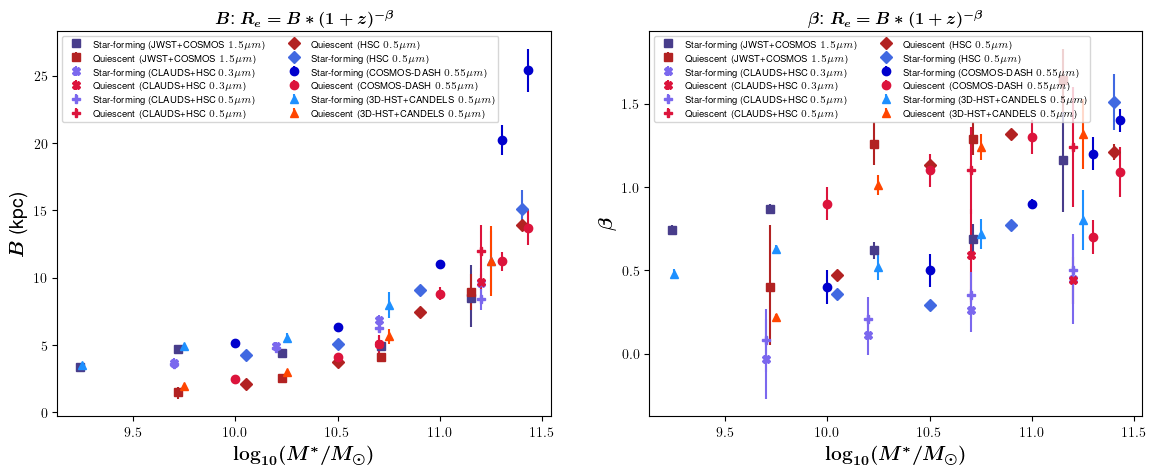

In [107]:
def make_data_plots(data, validation_info, authors, info_keys = ['Re_vs_Mstar', 'Re_vs_z'],
                    summary_only=False, plttype='.png', fits={}, xpltname='',):
    sum_fig = None
    sum_ax = None
    for author in authors:
        for key in info_keys:
            plotter = validation_info[key]['plotter']
            pltname = '_'.join([key, '{}', xpltname]) if xpltname else '_'.join([key, '{}'])
            pltname = pltname + plttype
            if key in data.keys() and author in data[key].keys():
                save_summary = (author == authors[-1])
                sum_fig, sum_ax = plotter(data[key][author], author, validation_info[key],
                                          pltname='{}_{{}}'.format(key), summary_only=summary_only,
                                          summary_fig=sum_fig, summary_ax=sum_ax, save_summary=save_summary)


make_data_plots(data, validation_info, authors, info_keys=['Re_vs_z'], summary_only=True)

Saving /Users/kovacs/cosmology/diff_notebooks/SizePlots/Re_vs_Mstar_kawinwanichakij_2021
Saving /Users/kovacs/cosmology/diff_notebooks/SizePlots/Re_vs_Mstar_mowla_2019
Saving /Users/kovacs/cosmology/diff_notebooks/SizePlots/Re_vs_Mstar_george_2024_3000
Saving /Users/kovacs/cosmology/diff_notebooks/SizePlots/Re_vs_Mstar_george_2024_5000
Saving /Users/kovacs/cosmology/diff_notebooks/SizePlots/Re_vs_Mstar_summary


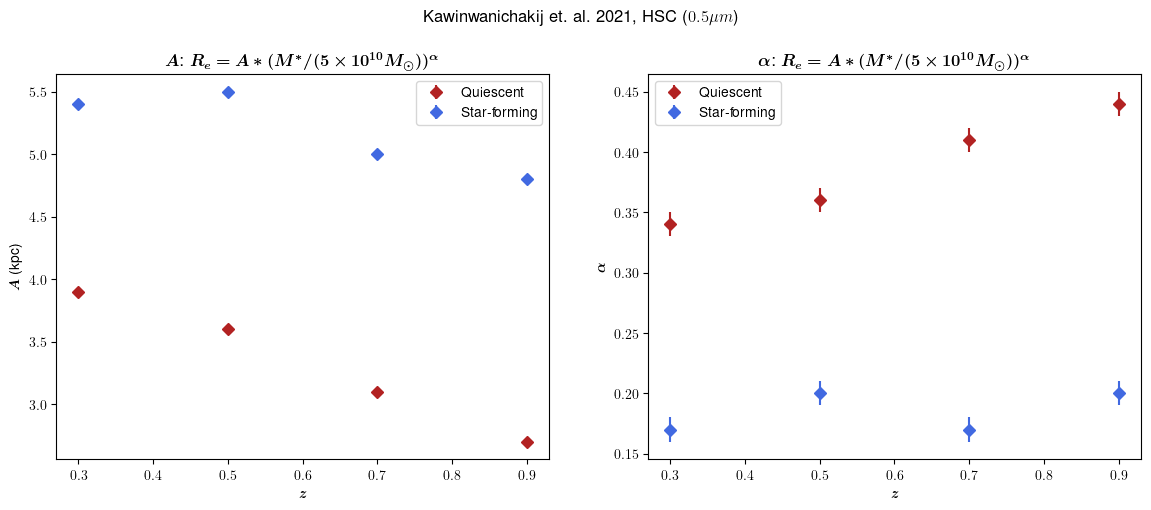

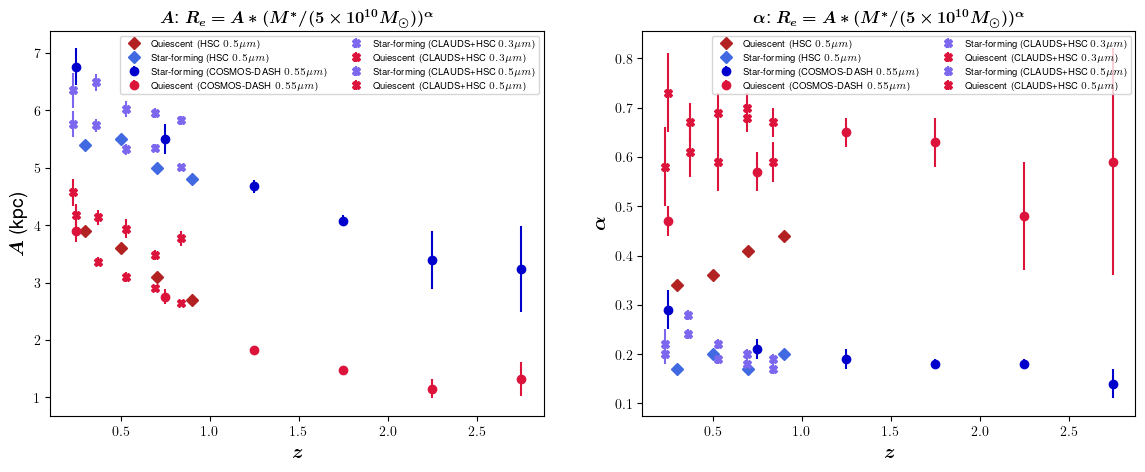

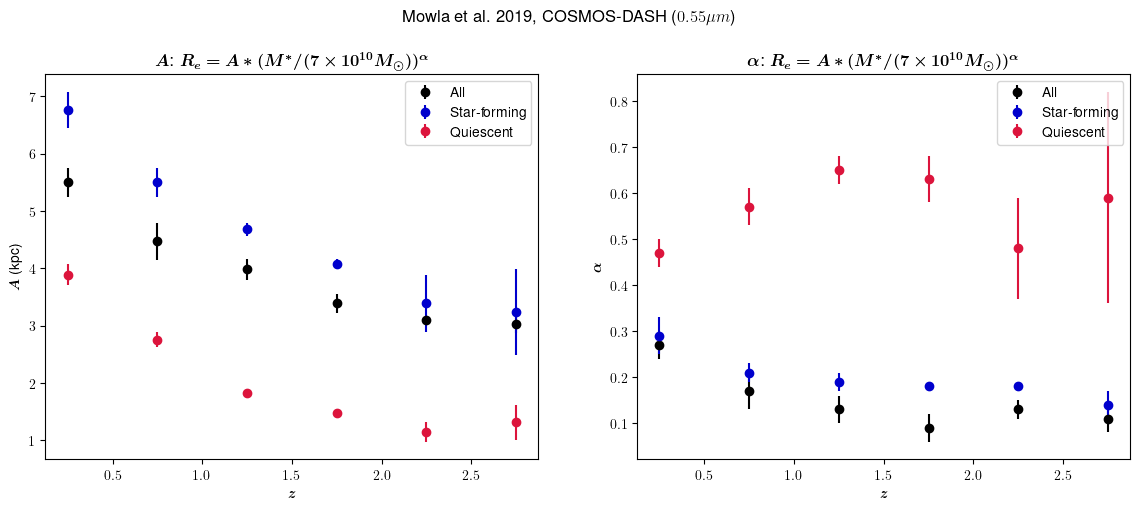

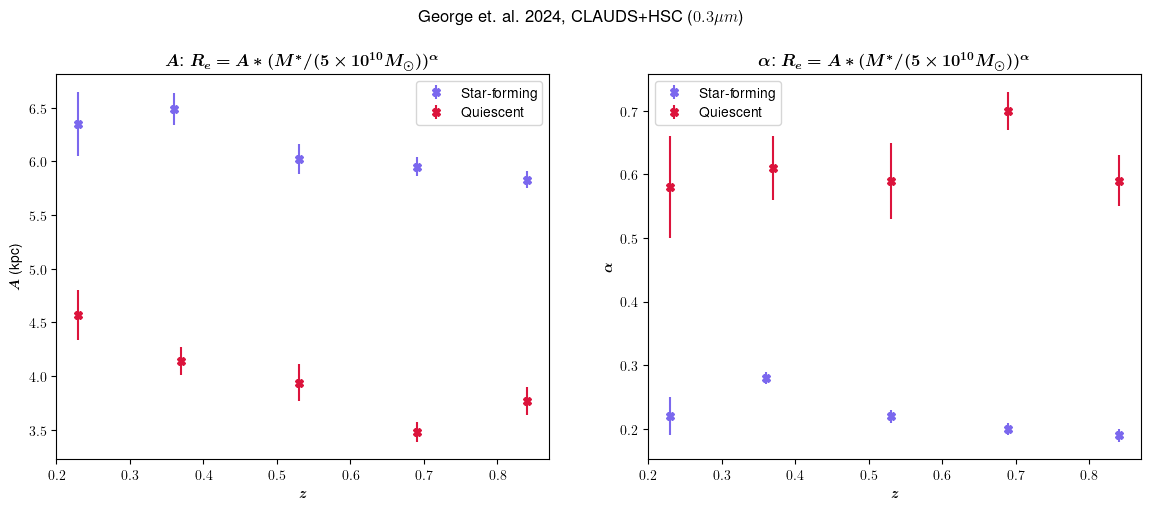

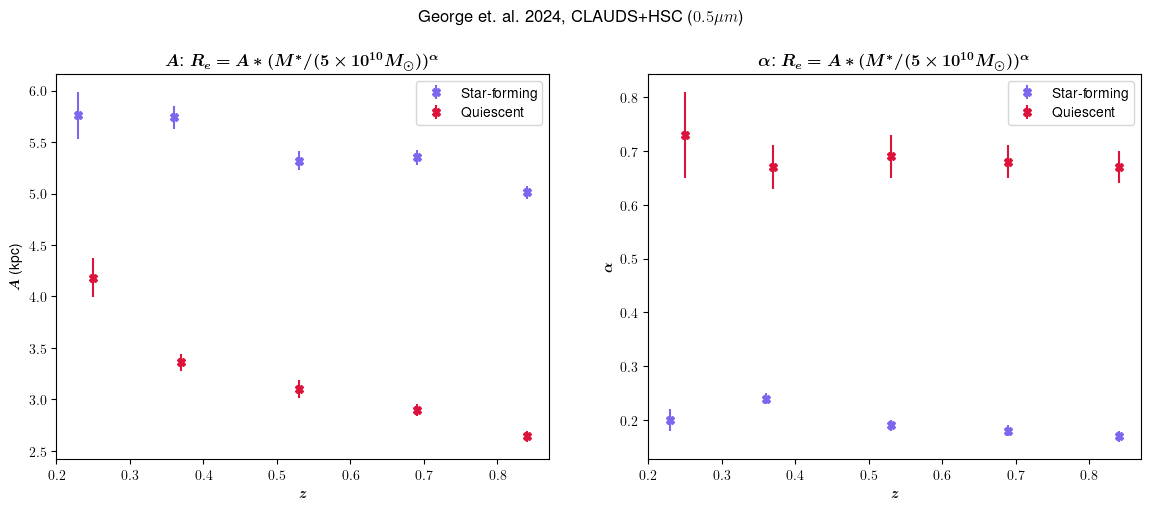

In [112]:
make_data_plots(Rmdata, validation_info, authors_rm, info_keys=['Re_vs_Mstar'], summary_only=False)

In [ ]:
# fit data points for B and beta with a power law in M*
from scipy.optimize import curve_fit
    
# collect data points
def get_data_vectors(data, val_info, sample='Star-forming', lambda_min=0.5, lambda_max=1.0,
                     X='x-values', Y='y-values', dYp='y-errors+', dYn='y-errors-'):
    #initialize
    xvec = np.asarray([])
    yvec = []
    dyvec = []
    for yname in val_info[Y]:
        yvec.append(np.asarray([]))
        dyvec.append(np.asarray([]))
    for k, v in data.items():
        wave = val_info[k]['wavelength']
        if wave >= lambda_min and wave <= lambda_max:
            print('Processing {} {}'.format(k, wave))
            add_xvec = True
            #print(val_info[X], xvec)
            for n, (y, dy, yn, dynp, dynn) in enumerate(zip(yvec, dyvec, val_info[Y],
                                                            val_info[dYp], val_info[dYn])):
                #print(yname,  v[yname.format(sample)])
                mask = np.abs(v[yn.format(sample)]) > 0.
                if add_xvec:
                    xvec = np.concatenate((xvec, v[val_info[X]][mask]))
                    add_xvec = False
                y = np.concatenate((y, v[yn.format(sample)][mask]))
                yerr = np.fmax(v[dynp.format(sample)], v[dynn.format(sample)])
                dy = np.concatenate((dy, yerr[mask]))
                yvec[n] = y
                dyvec[n] = dy
        else:
            print('Skipping {} {}'.format(k, wave))
            
        

    assert(all([len(xvec) == len(y) for y in yvec])), 'Mismatch in assembled data vectors'
    return xvec, yvec, dyvec

In [ ]:
data_vectors = {}
fit_type = 'Re_vs_z'
data_vectors['Re_vs_z'] = {}
samples = ['Star-forming', 'Quiescent']
for sample in samples:
    data_vectors[fit_type][sample] = {}
    x, y, dy = get_data_vectors(data[fit_type], validation_info[fit_type], sample=sample)
    data_vectors[fit_type][sample][validation_info[fit_type]['x-values']] = x
    data_vectors[fit_type][sample]['y'] = y
    data_vectors[fit_type][sample]['dy'] = dy

author_list = get_author_list(validation_info['Re_vs_z'], lambda_min=0.5, lambda_max=1.0)

In [ ]:
def pwrfit(x, x0, a, b):
    return a*np.power(x-x0, b)

def expfit(x, x0, a, b):
    return a*np.exp(b*(x-x0))

def _sigmoid(x, x0, k, ymin, ymax):
    height_diff = ymax - ymin
    return ymin + height_diff / (1 + np.exp(-k * (x - x0)))

#The variable xtp is not a free parameter, it is simply the abscissa value at which the normalization free parameter ytp is defined
def _sig_slope(x, xtp, ytp, x0, slope_k, lo, hi):
    slope = _sigmoid(x, x0, slope_k, lo, hi)
    return ytp + slope * (x - xtp)

def fit_parameters(data_vectors, samples, val_info, p0_values,
                   func=_sigmoid):
    parameters = val_info['y-values']
    fits = {}
    for sample, p0_row in zip(samples, p0_values):
        M = data_vectors[sample][val_info['x-values']]
        for par, p0, y, dy in zip(parameters, p0_row,
                                  data_vectors[sample]['y'],
                                  data_vectors[sample]['dy']):
            #print(par, M, y, dy, p0)
            fit_key = par.format(sample)
            fits[fit_key] = {}
            popt, pcov = curve_fit(func, M, y, sigma=dy, p0=p0, absolute_sigma=True)
            perr = np.sqrt(np.diag(pcov))
            fits[fit_key]['popt'] = popt
            fits[fit_key]['perr'] = perr
            fits[fit_key]['pcov'] = pcov
            print('Fit parameters: ', fit_key, popt)
            print('Errors: ', fit_key, perr)

    #print(fits)
    return fits

def plot_fits(fits, data_vectors, samples, val_info, data={}, authors=None,
              func=_sigmoid, title='', dYp='y-errors+', dYn='y-errors-',
              plotdir=os.path.join(notebook_dir, 'SizePlots'), fontsize=12,
              pltname='Fit_Re_vs_z{}.png', fit_label='\\log(M^*/M_\\odot)',
             ):
    
    parameters = val_info['y-values']
    nrow = len(samples)
    ncol = len(parameters)
    fig, ax_all = plt.subplots(nrow, ncol, figsize=(ncol * 7, nrow * 5))
    colors = ('blue', 'red') #for simple plot
    for sample, ax_row, color in zip(samples, ax_all, colors):
        M = data_vectors[sample][val_info['x-values']]
        for par, ax, y, dy, dYp, dYn, xlabel, ylabel in zip(parameters, ax_row,
                                                            data_vectors[sample]['y'],
                                                            data_vectors[sample]['dy'],
                                                            val_info['y-errors+'],
                                                            val_info['y-errors-'],
                                                            val_info['xlabels'],
                                                            val_info['ylabels'],
                                                            ):
            fit_key = par.format(sample)
            if not authors:
                ax.errorbar(M, y, yerr=dy, label=fit_key, color=color, marker='o', linestyle='')
            else: #fancy plot with full legend
                for author in authors:
                    idx = val_info[author]['samples'].index(sample)
                    mcolor = val_info[author]['colors'][idx]
                    xcol = val_info['x-values']
                    ycol = fit_key
                    yerr = np.fmax(data[author][dYp.format(sample)],
                                   data[author][dYn.format(sample)])
                    #mask for missing values
                    yvalues = data[author][fit_key]
                    mask = np.abs(yvalues) > 0.
                    marker = val_info[author]['marker']
                    sum_label = '{} ({}) ${}\\mu m$'.format(sample, val_info[author]['short_title'],
                                                val_info[author]['wavelength'])
                    ax.errorbar(data[author][xcol][mask], yvalues[mask],
                                yerr=yerr[mask], label=sum_label,
                                color=mcolor, marker=marker, linestyle='')
            popt =  fits[fit_key]['popt']
            Msort = np.sort(M)
            label = '$\\bm{{{:.2g}+({:.2g}-{:.2g})/(1+\\exp(-{:.2g}*({} -{:.3g})))}}$'.format(
                    popt[2], popt[3], popt[2], popt[1], fit_label, popt[0])
            ax.plot(Msort, func(Msort, *popt), color='black', label=label)
            ax.set_xlabel(xlabel, fontsize=fontsize)
            ax.set_ylabel(ylabel, fontsize=fontsize)
            ax.set_title(sample)
            legend_properties = {'weight':'bold'}
            ax.legend(loc='best', fontsize='small', prop=legend_properties)

    #fig.suptitle('{} ({})'.format())
    save_fig(fig, plotdir, pltname.format(title))        
    return

In [ ]:
p0_values = [[(11.5, 2.7, 3.0, 40.0), (11.3, 2.5, 0.15, 2.5)], [(11.0, 3.6, 1.5, 16.0), (10.0, 8.0, 0.4, 1.2)]]
fit_type='Re_vs_z'
# test p0 values initialize fits with p0 values and plot
fits={}
fits[fit_type] = {}
for sample, p0_row in zip(samples, p0_values):
    for par, p0 in zip(validation_info[fit_type]['y-values'], p0_row):
        fit_key = par.format(sample)
        fits[fit_type][fit_key] = {} #if fit_key not in fits[fit_type].keys()
        fits[fit_type][fit_key]['popt'] = p0

plot_fits(fits[fit_type], data_vectors[fit_type], samples, validation_info[fit_type], func=_sigmoid, title='_InitialGuess')
fits[fit_type] = fit_parameters(data_vectors[fit_type], samples, validation_info[fit_type], p0_values, func=_sigmoid)
plot_fits(fits[fit_type], data_vectors[fit_type], samples, validation_info[fit_type], func=_sigmoid,
          data=data[fit_type], authors=author_list)

In [ ]:
def median_size_vs_z(z, B, beta):
    Re_med = B*np.power(1+z, -beta)
    return Re_med

def get_color_mask(color, sample, UVJcolor_cut=1.5, UVJ=True):
    mask = np.ones(len(color), dtype=bool)
    if sample == 'Star-forming':
        if UVJ:
            mask = (color < UVJcolor_cut)
        else:
            print('Unknown color option')
    else:
        if UVJ:
            mask = (color >= UVJcolor_cut)
        else:
            print('Unknown color option')    
    return mask

def get_median_sizes(fits, log_Mstar, redshift, color, Ngals, samples, parameters,
                     UVJcolor_cut=1.5, fit_func=_sigmoid, size_func=median_size_vs_z):
    R_med = np.zeros(Ngals) 
    #determine parameter values from fits 
    for sample in samples:
        mask = get_color_mask(color, sample, UVJcolor_cut=UVJcolor_cut)
        #print(sample, np.count_nonzero(mask), mask)
        fit_parameters = []
        for par in parameters:
            parameter = par.format(sample)
            popt = fits[parameter]['popt']
            #print(parameter, popt)
            fit_parameters.append(fit_func(log_Mstar[mask], *popt))
 
        R_med[mask] = size_func(redshift[mask], *fit_parameters)

    return R_med

def get_scatter(R_med, scatter_hi, scatter_lo):
    scatter_up = R_med*(np.power(10, scatter_hi) - 1)
    scatter_down = R_med*(1 - np.power(10, -scatter_lo))
    return scatter_up, scatter_down

def generate_sizes(fits, log_Mstar, redshift, color, parameters,
                   samples=['Star-forming', 'Quiescent'],
                   UVJcolor_cut=1.5, scatter_hi=0.2, scatter_lo=0.2,
                   fit_func=_sigmoid, size_func=median_size_vs_z,
                   ):
    """
    fits: dictionary of fit parameters
    log_Mstar: array length (Ngals), log10(stellar masses) of galaxies in units of Msun
    redshift: array length Ngals, redshift of galaxies
    color: array length Ngals, color of galaxies

    returns
    sizes: array length (Ngals), size in kpc

    """
    Ngals = len(log_Mstar)
    assert(len(redshift)==Ngals), "Supplied redshifts don't match length of M* array" 
    assert(len(color)==Ngals), "Supplied colors don't match length of M* array"

    R_med = get_median_sizes(fits, log_Mstar, redshift, color, Ngals, samples, parameters,
                             UVJcolor_cut=UVJcolor_cut,
                             fit_func=fit_func, size_func=size_func)
    scatter_up, scatter_down  = get_scatter(R_med, scatter_hi=scatter_hi, scatter_lo=scatter_lo)

    sizes_hi = np.random.normal(loc=R_med, scale=scatter_hi, size=Ngals)
    sizes_lo = np.random.normal(loc=R_med, scale=scatter_lo, size=Ngals)       

    return np.where(sizes_lo < R_med, sizes_lo, sizes_hi), R_med, scatter_up, scatter_down 
    

In [ ]:
#test sizes
N = 5000
lM_lo = 9.0
lM_hi = 12.0
z_lo = 0.
z_hi = 3.0
log_Mstar = np.random.uniform(low=lM_lo, high=lM_hi, size=N)
redshift = np.random.uniform(low=z_lo, high=z_hi, size=N)
color_gal = np.random.uniform(low=-0.2, high=2.3, size=N)
#print(log_Mstar, redshift, color)
Re, R_med, scatter_up, scatter_down = generate_sizes(fits[fit_type], log_Mstar, redshift, color_gal,
                                                                         validation_info[fit_type]['y-values'])
print(np.min(R_med), np.max(R_med))
print(np.min(Re), np.max(Re))

In [ ]:
from scipy.stats import binned_statistic
qs = [Re, R_med, scatter_up, scatter_down]
nrow, ncol = get_nrow_ncol(len(qs))
fig, ax_all = plt.subplots(nrow, ncol, figsize=(ncol * 7, nrow * 5))
for ax, q in zip(ax_all.flat, qs):
    ax.hist(q, bins=40)

In [ ]:
tests = [{}, {}]
print(samples)
for test, ikey in zip(tests, ['Re_vs_z_data', 'Re_vs_Mstar_data']):
    if 'Mstar' in ikey:
        for sample in samples:
            test= read_size_data(test, authors, info_key=ikey, sample=sample)
    else:
        test= read_size_data(test, authors, info_key=ikey)
    print(test[ikey].keys())


In [ ]:
from scipy.stats import binned_statistic
from itertools import zip_longest
def plot_generated_sizes(Re, R_med, color_gal, log_Mstar, redshift, 
                         samples, authors, data, val_info, 
                         z_lo=0., z_hi=3.0, Nz=7, logM_lo=9.0, logM_hi=12.0, NM=6,
                         plotdir=os.path.join(notebook_dir, 'SizePlots'), fontsize=12,
                         fits={}, pltname='GalaxySizes_vs_Mstar_zbins_{}.png'):

    #logM_bins = np.linspace(np.floor(log_Mstar), np.ceil(log_Mstar)
    z_bins = np.linspace(z_lo, z_hi, Nz)
    nrow, ncol = get_nrow_ncol(len(z_bins))
    pt_colors = ('royalblue', 'tomato') #for simple plot
    med_colors = ('blue', 'red')
    
    fig, ax_all = plt.subplots(nrow, ncol, figsize=(ncol * 7, nrow * 5))
    for ax, z_min, z_max in zip_longest(ax_all.flat, z_bins[0:-1], z_bins[1:]):
        if z_min is None:
            ax.set_visible(False)
            continue
        zmask = (redshift >= z_min) & (redshift < z_max)
        for sample, pcolor, med_color in zip(samples, pt_colors, med_colors):
            cmask = get_color_mask(color_gal, sample)
            mask = zmask & cmask
            ztitle = '${:.1f} \\leq z < {:.1f}$'.format(z_min, z_max)
            ax.scatter(log_Mstar[mask], Re[mask], color=pcolor, alpha=0.4, label=sample)
            # profile plot of Mstar vs R_med
            
            result = binned_statistic(log_Mstar[mask], [R_med[mask], R_med[mask]**2], bins=NM,
                                                  range=(logM_lo, logM_hi), statistic='mean')
            means, means2 = result.statistic
            std_dev = np.sqrt(means2 - means**2)
            bin_edges = result.bin_edges
            bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
            ax.plot(bin_centers, means, color=med_color, label='{} $\\bm{{R_e^{{med}} }}$'.format(sample),
                    linewidth=3)
            for author in authors:
                if ztitle not in data[author].keys() and 'z-values' not in val_info.keys():
                    print('..Skipping bin {} for {}: no data'.format(ztitle, author))
                    continue
                if ztitle in data[author].keys(): #choose sub-dict
                    v = data[author][ztitle]
                else: # create mask if no subdict
                    v = data[author]
                    zcol = val_info['z-values']
                    zval_mask = (v[zcol] >= z_min) & (v[zcol] < z_max)
                idx = val_info[author]['samples'].index(sample)
                dcolor = val_info[author]['colors'][idx]
                for ycol, yerrp, yerrn in zip(val_info['y-values'],
                                              val_info['y-errors+'],
                                              val_info['y-errors-'],
                                                 ): # so far these are 1-entry lists
                    xcol = val_info['x-values'].format(sample)
                    ycol = ycol.format(sample)
                    mask = v[xcol] > 0.
                    #print(np.count_nonzero(zval_mask), np.count_nonzero(mask))
                    if ztitle not in data[author].keys(): mask = mask & zval_mask
                    if np.count_nonzero(mask) > 0:
                        
                        label = '{} {} ({} ${}\\mu m$)'.format(sample, val_info['lgnd_label'],
                                                             val_info[author]['short_title'],
                                                             val_info[author]['wavelength'])
                        #label = '{} {}'.format(val_info['lgnd_label'], sample)
                        if ztitle in data[author].keys():
                            ax.plot(v[xcol][mask], v[ycol][mask], color=dcolor, label=label)
                            y_upper = v[ycol][mask] + v[yerrp.format(sample)][mask]
                            y_lower = v[ycol][mask] - v[yerrn.format(sample)][mask] 
                            ax.fill_between(v[xcol][mask], y_lower, y_upper,
                                        facecolor=dcolor, alpha=0.2)
                        else:
                            ax.errorbar(v[xcol][mask], v[ycol][mask], yerr=v[yerrp.format(sample)][mask],
                                        color=dcolor, label=label, linestyle='',
                                        marker=val_info[author]['marker'])
                        
            ax.legend(loc='best')
            ax.set_title(ztitle)
            ax.set_xlabel(val_info['xlabel'])
            ax.set_ylabel(val_info['ylabel'])
    short_titles = [val_info[author]['short_title'] for author in authors]
    author_list = '_'.join(authors)
    title_list = '+'.join(short_titles)
    fig.suptitle('Generated Sizes and {} Data'.format(title_list), y=0.92,
                 fontweight="bold")
    save_fig(fig, plotdir, pltname.format(author_list)) 
            
    return
                         

In [ ]:
# make validation plots
for test, ikey in zip(tests, ['Re_vs_z_data', 'Re_vs_Mstar_data']):
    authors = get_author_list(validation_info[ikey])
    plot_generated_sizes(Re, R_med, color_gal, log_Mstar, redshift, samples, 
                         authors, test[ikey], validation_info[ikey])
